In [1]:
DATA_PATH = "/nfs_home/nallapar/final/riboclette/riboclette/models/preds_h5s"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.transforms import Affine2D
from matplotlib.transforms import ScaledTranslation
import seaborn as sns
import scienceplots
import numpy as np
import re
import os
from permetrics import RegressionMetric
import h5py
from collections import defaultdict
from tqdm.auto import tqdm
from itertools import product
import matplotlib.patches as patches
import cairosvg
import skunk

In [3]:
os.listdir(DATA_PATH)

['XLNet-DH_S4.h5',
 'XLNet-PLabelDH_exp2_S3.h5',
 'RiboMIMO_S42.h5',
 'BiLSTM-DH_S1.h5',
 'XLNet-PLabelDH_exp1_S3.h5',
 'RiboMIMO_S4.h5',
 'XLNet-DH_S3.h5',
 'BiLSTM-CSH_S4.h5',
 'BiLSTM-DH_S42.h5',
 'XLNet-PLabelDH_exp2_S1.h5',
 'XLNet-PLabelDH_exp2_S4.h5',
 'XLNet-DH_S1.h5',
 'XLNet-CSH_S3.h5',
 'XLNet-DH_S2.h5',
 'BiLSTM-DH_S2.h5',
 'BiLSTM-CSH_S42.h5',
 'BiLSTM-DH_S3.h5',
 'XLNet-PLabelDH_exp1_S1.h5',
 'RiboMIMO_S1.h5',
 'XLNet-PLabelDH_exp1_S2.h5',
 'BiLSTM-CSH_S3.h5',
 'XLNet-CSH_S2.h5',
 'XLNet-PLabelDH_exp1_S4.h5',
 'RiboMIMO_S3.h5',
 'XLNet-PLabelDH_exp1_S42.h5',
 'XLNet-PLabelDH_exp2_S2.h5',
 'RiboMIMO_S2.h5',
 'XLNet-PLabelDH_exp2_S42.h5',
 'XLNet-CSH_S1.h5',
 'BiLSTM-CSH_S1.h5',
 'XLNet-DH_S42.h5',
 'BiLSTM-CSH_S2.h5',
 'BiLSTM-DH_S4.h5',
 'XLNet-CSH_S4.h5',
 'XLNet-CSH_S42.h5']

In [13]:
BRIGHT_PALETTE = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB', '#BBBBBB']
MODELS_PROP=[
    ('RiboMIMO', 'RiboMIMO', 'RM', False, BRIGHT_PALETTE[0]),
    ('BiLSTM-CSH', 'BiLSTM [SH]', 'BLSH', False, BRIGHT_PALETTE[1]),
    ('BiLSTM-DH', 'BiLSTM [DH]', 'BLDH', True, BRIGHT_PALETTE[2]),
    ('XLNet-CSH', 'Riboclette [SH]', 'RSH', False, BRIGHT_PALETTE[3]),
    ('XLNet-DH', 'Riboclette [DH]', 'RDH', True,BRIGHT_PALETTE[4]),
    ('XLNet-PLabelDH_exp1', 'Riboclette [DH] + PL [T]', 'RDHPLT', True,BRIGHT_PALETTE[5]),
    ('XLNet-PLabelDH_exp2', 'Riboclette [DH] + PL [G]', 'RDHPLG', True,BRIGHT_PALETTE[6]),
]
MODELS_PROP = pd.DataFrame(MODELS_PROP).rename(columns={0:'fname', 1:'model', 2:'abbr',3:'is_dh',4:'color'})
MODELS_PROP

,fname,model,abbr,is_dh,color
0,RiboMIMO,RiboMIMO,RM,False,#4477AA
1,BiLSTM-CSH,BiLSTM [SH],BLSH,False,#EE6677
2,BiLSTM-DH,BiLSTM [DH],BLDH,True,#228833
3,XLNet-CSH,Riboclette [SH],RSH,False,#CCBB44
4,XLNet-DH,Riboclette [DH],RDH,True,#66CCEE
5,XLNet-PLabelDH_exp1,Riboclette [DH] + PL [T],RDHPLT,True,#AA3377
6,XLNet-PLabelDH_exp2,Riboclette [DH] + PL [G],RDHPLG,True,#BBBBBB


In [14]:
from abc import ABC, abstractmethod

class Metric(ABC):
    @abstractmethod
    def compute(self, y_true, y_pred):
        pass

    def masked_compute(self, y_true, y_pred):
        nan_mask = ~np.isnan(y_true)
        y_true = y_true[nan_mask]
        y_pred = y_pred[nan_mask]
        return self.compute(y_true, y_pred)

In [15]:
class PCC(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.pearson_correlation_coefficient()
    
class MAE(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.mean_absolute_error()

class MAAPE(Metric):
    def compute(self, y_true, y_pred, eps=1e-10):
        evaluator = RegressionMetric(y_true+eps, y_pred)
        return evaluator.mean_arctangent_absolute_percentage_error()

In [16]:
metric_to_func = dict(
    PCC=PCC(),
    MAE=MAE(),
    MAAPE=MAAPE()
)

In [17]:
def compute_performance_metrics(fpath, abbr, is_dh, seed):
    sample_perf = defaultdict(list)
    with h5py.File(fpath, 'r') as f:
        if is_dh:
            ctrl_pred = f['y_pred_ctrl'][:]
            depr_pred = f['y_pred_depr_diff'][:]
            ctrl_true = f['y_true_ctrl'][:]
            depr_true = f['y_true_dd'][:]

        cond_pred = f['y_pred_full'][:]
        cond_true = f['y_true_full'][:]

        conditions = f['condition'][:].astype('U')
        conditions = np.char.replace(conditions, '-', '_')

        transcripts = [re.sub(r'[^A-Za-z0-9.]', '', t) for t in f['transcript'][:].astype('U')]

        for sample_idx in range(cond_true.shape[0]):
            condition = conditions[sample_idx]
            for m, f in metric_to_func.items():
                
                if is_dh and condition != 'CTRL':
                    depr_val = f.masked_compute(y_true=depr_true[sample_idx], y_pred=depr_pred[sample_idx])
                else:
                    depr_val = None
                sample_perf[f"depr_{m}"].append(depr_val)

                if is_dh:
                    ctrl_val = f.masked_compute(y_true=ctrl_true[sample_idx], y_pred=ctrl_pred[sample_idx])
                else:
                    ctrl_val = None
                sample_perf[f"ctrl_{m}"].append(ctrl_val)

                sample_perf[f"cond_{m}"].append(
                   f.masked_compute(y_true=cond_true[sample_idx], y_pred=cond_pred[sample_idx]))

            sample_perf["condition"].append(condition)
            sample_perf["n_codons"].append(len(cond_true[sample_idx]))

            sample_perf["transcript"].append(transcripts[sample_idx])

            # sample_perf["depr_skew"].append(skew(depr_true[sample_idx], nan_policy="omit"))
            # sample_perf["depr_kurtosis"].append(kurtosis(depr_true[sample_idx], nan_policy="omit"))
            # sample_perf["depr_var"].append(np.nanvar(depr_true[sample_idx]))
            # sample_perf["depr_std"].append(np.nanstd(depr_true[sample_idx]))
            # sample_perf["depr_mean"].append(np.nanmean(np.abs(depr_true[sample_idx])))
            # sample_perf["depr_max"].append(np.nanmax(depr_true[sample_idx]))

            # sample_perf["ctrl_skew"].append(skew(ctrl_true[sample_idx], nan_policy="omit"))
            # sample_perf["ctrl_kurtosis"].append(kurtosis(ctrl_true[sample_idx], nan_policy="omit"))
            # sample_perf["ctrl_var"].append(np.nanvar(ctrl_true[sample_idx]))
            # sample_perf["ctrl_std"].append(np.nanstd(ctrl_true[sample_idx]))
            # sample_perf["ctrl_mean"].append(np.nanmean(ctrl_true[sample_idx]))

            # sample_perf["cond_mean"].append(np.nanmean(cond_true[sample_idx]))

    return pd.DataFrame(sample_perf).assign(abbr=abbr, seed=seed)

In [18]:
from itertools import product 

data=pd.concat([
    compute_performance_metrics(os.path.join(DATA_PATH, f'{fname}_S{seed}.h5'), abbr, is_dh, seed)
    for (_, (fname, _, abbr, is_dh, _)), seed in tqdm(list(product(MODELS_PROP.iterrows(), [1,2,3,4,42])))
])

  0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipykernel_1497987/356418292.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data=pd.concat([


In [19]:
data = data.replace({
    'condition': {
        'VAL': 'VAL (V)',
        'ILE': 'ILE (I)',
        'LEU': 'LEU (L)',
        'LEU_ILE': '(L, I)', 
        'LEU_ILE_VAL': '(L, I, V)'}})

In [20]:
data

,depr_PCC,ctrl_PCC,cond_PCC,depr_MAE,ctrl_MAE,cond_MAE,depr_MAAPE,ctrl_MAAPE,cond_MAAPE,condition,n_codons,transcript,abbr,seed
0,NaN,NaN,0.714548,NaN,NaN,0.517444,NaN,NaN,0.723815,CTRL,737,ENSMUST00000163119.7,RM,1
1,NaN,NaN,0.649780,NaN,NaN,0.550386,NaN,NaN,0.702873,CTRL,734,ENSMUST00000156859.2,RM,1
2,NaN,NaN,0.571608,NaN,NaN,0.686812,NaN,NaN,0.800236,CTRL,724,ENSMUST00000164309.2,RM,1
3,NaN,NaN,0.565234,NaN,NaN,0.710049,NaN,NaN,0.832840,CTRL,533,ENSMUST00000151287.7,RM,1
4,NaN,NaN,0.300970,NaN,NaN,0.641619,NaN,NaN,0.588485,CTRL,483,ENSMUST00000026119.7,RM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,0.381644,0.749715,0.734209,0.168200,0.215803,0.218890,0.874772,0.619662,0.678407,"(LEU, ILE, VAL)",548,ENSMUST00000231039.1,RDHPLG,42
4248,0.342723,0.833160,0.768632,0.134156,0.224993,0.221211,0.927801,0.768025,0.685325,"(LEU, ILE, VAL)",60,ENSMUST00000231720.1,RDHPLG,42
4249,0.425482,0.640273,0.722313,0.169268,0.264238,0.264580,0.827069,0.629097,0.625713,"(LEU, ILE, VAL)",223,ENSMUST00000233580.1,RDHPLG,42
4250,0.151138,0.585411,0.249932,0.189568,0.262165,0.332349,0.926078,0.723051,0.713119,"(LEU, ILE, VAL)",100,ENSMUST00000233581.1,RDHPLG,42


In [20]:
data.query('(abbr == "RDHPLT" and seed == 1) or (abbr == "RM" and seed == 1)').pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC')

abbr                              RDHPLT        RM
transcript           condition                    
ENSMUST00000000001.4 (L, I)     0.826240  0.778202
                     (L, I, V)  0.785769  0.691990
                     CTRL       0.801218  0.712671
                     ILE (I)    0.776473  0.643344
                     LEU (L)    0.786986  0.784389
...                                  ...       ...
ENSMUST00000233988.1 CTRL       0.711461  0.605366
                     ILE (I)    0.657871  0.564867
                     LEU (L)    0.717642  0.608369
                     VAL (V)    0.706335  0.566637
ENSMUST00000234651.1 CTRL       0.549940  0.579241

[4252 rows x 2 columns]

In [21]:
TEXTWIDTH_CM = 18.3
CM_TO_INCH = 1/2.54  # centimeters in inches
CONDITION_ORDER = ['CTRL', 'ILE (I)', 'LEU (L)', 'VAL (V)', '(L, I)', '(L, I, V)']

In [22]:
df_condition_pcc = (pd.read_csv('Performance.csv')
 .melt(id_vars='Condition', var_name='Model', value_name='PCC')
 .assign(
     Seed=lambda df: [[el for el in re.findall(r"S\d+", x)] for x in df.PCC],
     PCC=lambda df: [[float(el) for el in re.findall(r"\d+\.\d+", x)] for x in df.PCC])
 .explode(['Seed','PCC'])
 .replace({
     'Model': {
      ' XL-Net 1 (64+6) DH Seed Best': 'XLNet DH',
      'XL-Net 1 DH (PLabel)': 'XLNet DH+PL',
      'XL-Net 1 SH (L: MAE+PCC)': 'XLNet SH', 
      'LSTM DH (L: MAE+PCC)': 'LSTM DH',
      'LSTM SH (L: MAE+PCC)': 'LSTM SH'}, 
    'Condition': {
        'CTRL + Liver': 'CTRL', 
        'LEU_ILE': '(LEU, ILE)', 
        'LEU_ILE_VAL': '(LEU, ILE, VAL)'
    }}
))
df_condition_pcc

FileNotFoundError: [Errno 2] No such file or directory: 'Performance.csv'

In [23]:
palette_df = pd.DataFrame.from_dict(dict(
    Model = ['Riboclette DH+IM', 'Riboclette DH', 'LSTM DH', 'RiboMIMO'],
    Palette = np.array(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])[[0,1,4,5]]
))
palette_dict = dict(zip(palette_df['Model'], palette_df['Palette']))

In [24]:
df_condition_pcc = (
    pd.DataFrame.from_dict({
        'Order': [1, 3, 2, 5, 6, 4],
        'Condition': ['CTRL', 'LEU', 'ILE', '(LEU, ILE)', '(LEU, ILE, VAL)', 'VAL'],
        'Riboclette DH': [0.5979, 0.6893, 0.6382, 0.6798, 0.689, 0.6997],
        'LSTM DH': [0.525, 0.6092, 0.5163, 0.6005, 0.656, 0.6602],
        'RiboMIMO': [0.3898, 0.5958, 0.5421, 0.5899, 0.5888, 0.6129]
    })
    .melt(id_vars=['Condition', 'Order'], var_name='Model', value_name='PCC')
    .assign(Model=lambda df: pd.Categorical(df.Model, ['RiboMIMO', 'LSTM DH', 'Riboclette DH']))
    .sort_values('Model'))
df_condition_pcc

,Condition,Order,Model,PCC
17,VAL,4,RiboMIMO,0.6129
15,"(LEU, ILE)",5,RiboMIMO,0.5899
14,ILE,2,RiboMIMO,0.5421
13,LEU,3,RiboMIMO,0.5958
12,CTRL,1,RiboMIMO,0.3898
16,"(LEU, ILE, VAL)",6,RiboMIMO,0.5888
11,VAL,4,LSTM DH,0.6602
10,"(LEU, ILE, VAL)",6,LSTM DH,0.6560
9,"(LEU, ILE)",5,LSTM DH,0.6005
8,ILE,2,LSTM DH,0.5163


In [224]:
PCCs =[0.6816, 0.6759, 0.68, 0.6788, 0.6789] + [0.659, 0.6438, 0.6557, 0.6209, 0.6531] + [0.5831, 0.58, 0.5808, 0.5806, 0.5811] + [0.5532]
MAEs = [.218, .2213, .2176, .2168, .2198] + [0.2231, 0.231, 0.2242, 0.2328, 0.2232] + [np.nan] * 6
Models = ['Riboclette DH+IM'] * 5 + ['Riboclette DH'] * 5 + ['LSTM DH'] * 5 + ['RiboMIMO']

df_overall_pcc = (
    pd.DataFrame(np.array([PCCs, MAEs]).T, columns=['PCC', 'MAE']).assign(Model=Models)
    .assign(Model=lambda df: pd.Categorical(df.Model, ['RiboMIMO', 'LSTM DH', 'Riboclette DH', 'Riboclette DH+IM']))
    .sort_values('Model'))
df_overall_pcc

,PCC,MAE,Model
15,0.5532,NaN,RiboMIMO
10,0.5831,NaN,LSTM DH
11,0.5800,NaN,LSTM DH
12,0.5808,NaN,LSTM DH
13,0.5806,NaN,LSTM DH
14,0.5811,NaN,LSTM DH
5,0.6590,0.2231,Riboclette DH
6,0.6438,0.2310,Riboclette DH
7,0.6557,0.2242,Riboclette DH
8,0.6209,0.2328,Riboclette DH


In [45]:
df_imputation = (
    pd.DataFrame.from_dict({
        'Trainset Size': [17897] * 5 + [17897] * 5 + [92700] * 5 + [128808] * 5,
        'PCC': [0.659, 0.6438, 0.6557, 0.6209, 0.6531] + [0.6644, 0.6301, 0.6605, 0.6303, 0.6338] + [0.6793, 0.6768, 0.6795, 0.6795, 0.6817] + [0.6757, 0.6754, 0.6802, 0.6732, 0.6797],
        'MAE': [0.2231, 0.231, 0.2242, 0.2328, 0.2232] + [0.2198, 0.2273, 0.2226, 0.2198, 0.2198] + [0.2236, 0.2243, 0.2209, 0.2253, 0.2217] + [0.2198, 0.2271, 0.2197, 0.2269, 0.2264],
        'Imputed': ['None'] * 5 + ['T'] * 5 + ['(T, D)'] * 5 + ['(T, D, M)'] * 5,
        'Color': [PALETTE_TO_MODEL["Riboclette DH"]] * 5 + [BRIGHT_PALETTE[6]] * 5 + [PALETTE_TO_MODEL["Riboclette DH+IM"]] * 5 + [BRIGHT_PALETTE[5]] * 5
    }))
df_imputation

,Trainset Size,PCC,MAE,Imputed,Color
0,17897,0.6590,0.2231,None,#EE6677
1,17897,0.6438,0.2310,None,#EE6677
2,17897,0.6557,0.2242,None,#EE6677
3,17897,0.6209,0.2328,None,#EE6677
4,17897,0.6531,0.2232,None,#EE6677
5,17897,0.6644,0.2198,T,#BBBBBB
6,17897,0.6301,0.2273,T,#BBBBBB
7,17897,0.6605,0.2226,T,#BBBBBB
8,17897,0.6303,0.2198,T,#BBBBBB
9,17897,0.6338,0.2198,T,#BBBBBB


In [25]:
df_condition_pcc.groupby('Condition').Order.first().sort_values().index

Index(['CTRL', 'ILE', 'LEU', 'VAL', '(LEU, ILE)', '(LEU, ILE, VAL)'], dtype='object', name='Condition')

In [26]:
(df_condition_pcc
     .groupby(['Model', 'Seed'])
     .PCC
     .agg('mean')
     .reset_index()
     .groupby('Model')
     .PCC
     .agg(['mean', 'std'])
     .reset_index())

KeyError: 'Seed'

In [41]:
import os
# https://github.com/Kozea/CairoSVG/issues/392
os.environ['DYLD_LIBRARY_PATH']="/opt/homebrew/opt/cairo/lib"

In [78]:
seed_cond_mean=(data.groupby(['abbr', 'condition', 'seed'])
 .cond_PCC
 .mean()
 .reset_index())
(seed_cond_mean
    .query('abbr == "RM"')
    .groupby('condition')
    .cond_PCC
    .agg(['mean', 'std'])
    .reset_index()
    .set_index('condition')
    .loc[CONDITION_ORDER]
)

,mean,std
condition,,
CTRL,0.485016,0.009258
ILE,0.542895,0.009228
LEU,0.593447,0.009171
VAL,0.602412,0.006065
"(LEU, ILE)",0.580449,0.014530
"(LEU, ILE, VAL)",0.595214,0.005481


In [26]:
(data
        .groupby(['abbr', 'condition', 'seed'])
        .cond_PCC
        .mean()
        .groupby(['abbr', 'seed'])
        .mean()
        .groupby('abbr')
        .agg(['mean', 'std'])
        .reset_index()
        .merge(MODELS_PROP, on='abbr'))

,abbr,mean,std,fname,model,is_dh,color
0,BLDH,0.587228,0.001844,BiLSTMDH,BiLSTM [DH],True,#228833
1,BLSH,0.618849,0.000363,BiLSTMSH,BiLSTM [SH],False,#EE6677
2,RDH,0.645770,0.007780,XLNetDH,Riboclette [DH],True,#66CCEE
3,RDHPLG,0.674247,0.000756,XLNetPLabelDH_exp2,Riboclette [DH] + PL [G],True,#BBBBBB
4,RDHPLT,0.676467,0.001351,XLNetPLabelDH_exp1,Riboclette [DH] + PL [T],True,#AA3377
5,RM,0.566572,0.001272,RiboMIMO,RiboMIMO,False,#4477AA
6,RSH,0.631222,0.008505,XLNetSH,Riboclette [SH],False,#CCBB44


In [30]:
for a in MODELS_PROP[['abbr', 'color']].values:
    print(a)

['RM' '#4477AA']
['BLSH' '#EE6677']
['BLDH' '#228833']
['RSH' '#CCBB44']
['RDH' '#66CCEE']
['RDHPLT' '#AA3377']
['RDHPLG' '#BBBBBB']


In [ ]:
data.query('abbr == "RM"')

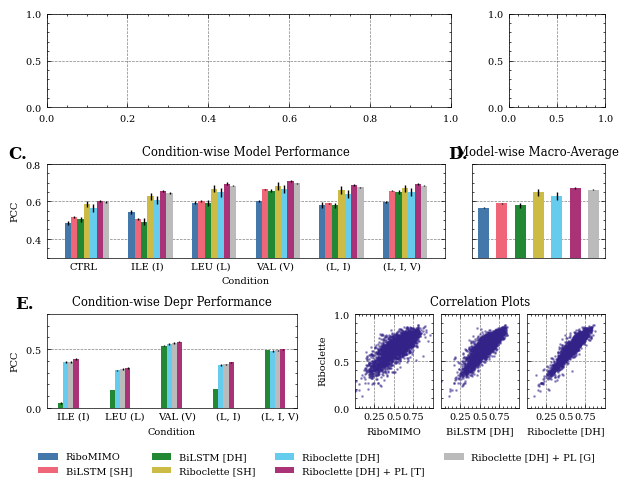

In [27]:
with plt.style.context(['science','nature','grid','bright','no-latex']):
    fig = plt.figure(figsize=(TEXTWIDTH_CM*CM_TO_INCH, 13*CM_TO_INCH))
    gs = fig.add_gridspec(nrows=3, ncols=4, wspace=.6, hspace=.6)
    ax0 = fig.add_subplot(gs[0,:-1])
    ax1 = fig.add_subplot(gs[0,-1])
    
    inner_grid = gs[1,:].subgridspec(ncols=2, nrows=1, wspace=0.1, width_ratios=[3,1])
    (ax2, ax3) = inner_grid.subplots(sharey=True)

    ax4 = fig.add_subplot(gs[2,:-2])

    inner_grid = gs[2,-2:].subgridspec(ncols=3, nrows=1, wspace=0.1)
    (ax5, ax6, ax7) = inner_grid.subplots(sharey=True)
    
    # ax0.grid(False)
    # ax0.spines['top'].set_visible(False)
    # ax0.spines['right'].set_visible(False)
    # ax0.spines['bottom'].set_visible(False)
    # ax0.spines['left'].set_visible(False)
    # ax0.get_xaxis().set_ticks([])
    # ax0.get_yaxis().set_ticks([])
    # ax0.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    # ax0.text(x=-0.05, y=1.1, s="A.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax0.transAxes)
    # skunk.connect(ax0, 'sk') 

    # data = (
    #     df_imputation.groupby('Imputed').agg({'PCC': ['mean', 'std'], 'Trainset Size': 'mean', 'Color': 'first'})
    #     .reset_index())
    # data.columns = ['Imputed', 'PCC_mean', 'PCC_std', 'Trainset Size', 'Color']
    # for idx, row in data.sort_values('Trainset Size').iterrows():
    #     if 'GC' in row.Imputed:
    #         print(row.Imputed)
    #         sign = 1 if 'IM' in row.Imputed else -1
    #         trans = Affine2D().translate(sign*1e3, 0.0) + ax3.transData
    #         ax1.errorbar(x=row['Trainset Size'], y=row['PCC_mean'], yerr=row['PCC_std'], fmt="o", markersize=2, capsize=2, label=row.Imputed, color=row.Color)
    #     else:
    #         ax1.errorbar(x=row['Trainset Size'], y=row['PCC_mean'], yerr=row['PCC_std'], fmt="o", markersize=2, capsize=2, label=row.Imputed, color=row.Color)
    # ax1.legend(title='Imputed')
    # ax1.set_xticks([v*1000 for v in [0, 25, 50, 75, 100, 125, 150]])
    # ax1.set_title("Pseudo-Labeling Performance")
    # ax1.set_xlabel("Trainset Size")
    # ax1.set_ylabel("PCC")
    # ax1.set_ylim((.6, .7))
    # ax1.ticklabel_format(style='sci',scilimits=(3,3),axis='x')
    # ax1.text(x=-0.05, y=1.1, s="B.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax1.transAxes)

    width = .1
    multiplier = -2.5
    x_ticks = np.arange(data.condition.nunique())
    seed_cond_mean = data.groupby(['abbr', 'condition', 'seed']).cond_PCC.mean().reset_index()
    for abbr, color in MODELS_PROP[['abbr', 'color']].values:
        group = (seed_cond_mean
                 .query('abbr == @abbr')
                 .groupby('condition')
                 .cond_PCC
                 .agg(['mean', 'std'])
                 .reset_index()
                 .set_index('condition')
                 .loc[CONDITION_ORDER]
        )
        model=MODELS_PROP.query('abbr == @abbr').model.values[0]
        #group=group.sort_values('Order')
        offset = width * multiplier
        rects = ax2.bar(height=group['mean'], yerr=group['std'],  x=x_ticks+offset, width=width, color=color, label=model)
        multiplier += 1

    #f1 = sns.barplot(x='Condition', y='PCC', hue='Model', palette=palette_dict, data=df_condition_pcc, ax=ax1)
    ax2.set_xticks(x_ticks, CONDITION_ORDER)
    ax2.set_ylim(0.3,.8)
    ax2.xaxis.grid(False)
    ax2.xaxis.set_ticks_position('none')

    ax2.set_ylabel('PCC')
    ax2.set_xlabel('Condition')
    ax2.set_title("Condition-wise Model Performance")
    ax2.text(x=-0.05, y=1.1, s="C.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax2.transAxes)

    width = .6
    df_overall_pcc = (data
        .groupby(['abbr', 'condition', 'seed'])
        .cond_PCC
        .mean()
        .groupby(['abbr', 'seed'])
        .mean()
        .groupby('abbr')
        .agg(['mean', 'std'])
        .reset_index()
        .merge(MODELS_PROP, on='abbr', how='right'))
    x_ticks = np.arange(df_overall_pcc.shape[0])
    ax3.bar(height=df_overall_pcc['mean'], yerr=df_overall_pcc['std'], x=x_ticks, color=df_overall_pcc.color, width=width)
    #ax3.set_xticks(x_ticks, [n for n, _ in df_overall_pcc.groupby('Model')], ha='center')
    ax3.set_xticks([])
    ax3.xaxis.set_ticks_position('none')
    ax3.xaxis.grid(False)
    ax3.set_ylim(.3,.8)
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
    ax3.set_title("Model-wise Macro-Average")
    ax3.text(x=-0.03, y=1.1, s="D.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax3.transAxes)

    DEPR_CONDITION_ORDER = CONDITION_ORDER[1:] 
    width = .1
    multiplier = -2.5
    x_ticks = np.arange(data.condition.nunique() - 1)
    seed_cond_mean = data.groupby(['abbr', 'condition', 'seed']).depr_PCC.mean().reset_index().dropna()
    for abbr in seed_cond_mean.abbr.unique():
        group = (seed_cond_mean
                 .query('abbr == @abbr')
                 .groupby('condition')
                 .depr_PCC
                 .agg(['mean', 'std'])
                 .reset_index()
                 .set_index('condition')
        )
        group = group.loc[DEPR_CONDITION_ORDER]
        color=MODELS_PROP.query('abbr == @abbr').color
        model=MODELS_PROP.query('abbr == @abbr').model.values[0]
        #group=group.sort_values('Order')
        offset = width * multiplier
        rects = ax4.bar(height=group['mean'], yerr=group['std'],  x=x_ticks+offset, width=width, color=color, label=model)
        multiplier += 1

    #f1 = sns.barplot(x='Condition', y='PCC', hue='Model', palette=palette_dict, data=df_condition_pcc, ax=ax1)
    ax4.set_xticks(x_ticks, DEPR_CONDITION_ORDER)
    ax4.set_ylim(0,.8)
    ax4.xaxis.grid(False)
    ax4.xaxis.set_ticks_position('none')
    ax4.set_ylabel('PCC')
    ax4.set_xlabel('Condition')
    ax4.set_title("Condition-wise Depr Performance")
    ax4.text(x=-0.05, y=1.1, s="E.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax4.transAxes)

    trans_wise_data = (
        data
        .query('(abbr == "RDHPLT" and seed == 1) or (abbr == "RM" and seed == 1)')
        .pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC'))
    ax5.scatter(y=trans_wise_data['RDHPLT'], x=trans_wise_data['RM'], s=1, color='#332288', alpha=.4)
    ax5.set_xlim(0,1)
    ax5.set_ylim(0,1)
    ax5.set_xlabel('RiboMIMO')
    ax5.set_ylabel('Riboclette')
    ax5.set_xticks([.25,.5,.75], [.25,.5,.75])
    #ax5.set_aspect('equal')
    #ax5.set_title("Model-wise Macro-Average")
    #ax5.text(x=-0.03, y=1.1, s="F.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax5.transAxes)

    trans_wise_data = (
        data
        .query('(abbr == "RDHPLT" and seed == 1) or (abbr == "BLDH" and seed == 1)')
        .pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC'))
    ax6.scatter(y=trans_wise_data['RDHPLT'], x=trans_wise_data['BLDH'], s=1, color='#332288', alpha=.4)
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xlabel('BiLSTM [DH]')
    ax6.set_xticks([.25,.5,.75], [.25,.5,.75])
    #ax6.set_aspect('equal')
    #ax6.set_title("Model-wise Macro-Average")
    #plt.tick_params('y', labelleft=False)
    #ax6.text(x=-0.03, y=1.1, s="F.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax6.transAxes)
    
    trans_wise_data = (
        data
        .query('(abbr == "RDHPLT" and seed == 1) or (abbr == "RDH" and seed == 1)')
        .pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC'))
    ax7.scatter(y=trans_wise_data['RDHPLT'], x=trans_wise_data['RDH'], s=1, color='#332288', alpha=.4)
    ax7.set_xlim(0,1)
    ax7.set_ylim(0,1)
    ax7.set_xticks([.25,.5,.75], [.25,.5,.75])
    ax7.set_xlabel('Riboclette [DH]')
    #ax7.set_aspect('equal')
    #ax7.set_title("Model-wise Macro-Average")
    #plt.tick_params('y', labelleft=False)
    #ax7.text(x=-0.03, y=1.1, s="F.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax7.transAxes)

    ax_title = fig.add_subplot(gs[2,-2:])
    ax_title.axis('off')
    ax_title.set_title('Correlation Plots')

    fig.legend(*ax2.get_legend_handles_labels(), bbox_transform=fig.transFigure, loc='center', bbox_to_anchor=(0.5, 0), borderaxespad=0., frameon=False, ncols=4)
    
    #sns.scatterplot(x="Trainset Size", y="PCC", hue='Experiment', data=df_imputation.groupby('Experiment').mean().reset_index(), ax=ax3)

    #data = df_imputation.groupby('Experiment').mean()
    #sns.scatterplot(x='MAE', y='PCC', hue='Experiment', data=data, ax=ax4)
    #err_df = (
    #    df_overall_pcc
    #    .groupby('Model')
    #    .agg({'PCC': ['mean', 'std'], 'MAE': ['mean', 'std']})
    #    .reset_index())
    #err_df.columns= err_df.columns.map('_'.join)
    #err_df = (
    #    err_df
    #    .rename(columns={'Model_': 'Model'})
    #    .dropna()
    #)

    #for _, row in err_df.iterrows():
    #    ax4.errorbar(x=row['MAE_mean'], y=row['PCC_mean'], xerr=row['MAE_std'], yerr=row['PCC_std'], color=palette_dict[row['Model']],fmt="o")
    #ax4.legend(bbox_to_anchor=(-.25, 1.15), loc=2, borderaxespad=0., frameon=False, ncols=2)
    

    # svg = skunk.insert(
    # {
    #     'sk': 'output/pseudolabel_diagram.svg'
    # })

    # cairosvg.svg2pdf(bytestring=svg, write_to='output/performance_panel.pdf')
    plt.savefig('../results/plots/performance_panel.pdf', dpi=600, bbox_inches='tight')

In [168]:
data = (
        df_imputation.groupby('Experiment').agg({'PCC': ['mean', 'std'], 'Trainset Size': 'mean'})
        .reset_index())
data.columns = ['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size']
data

,Experiment,PCC_mean,PCC_std,Trainset Size
0,ALL[IM],0.67936,0.001737,92700.0
1,GC,0.64650,0.015387,17897.0
2,GC[IM],0.64382,0.017126,17897.0
3,GEN[IM],0.67684,0.003004,128808.0


In [ ]:
with plt.style.context(['science','nature','grid','bright']):
    ax = plt.figure(constrained_layout=True, figsize=(TEXTWIDTH_CM*CM_TO_INCH, 6*CM_TO_INCH))
    
    data = (
        df_imputation.groupby('Experiment').agg({'PCC': ['mean', 'std'], 'Trainset Size': 'mean'})
        .reset_index())
    data.columns = data.columns.map(lambda x: '_'.join([str(i) for i in x]) if x[0] == 'PCC' else x[0])
    for idx, row in data.sort_values('Trainset Size').iterrows():
        if 'GC' in row.Experiment:
            sign = 1 if 'IM' in row.Experiment else -1
            trans = Affine2D().translate(sign*1e3, 0.0) + ax3.transData
            ax1.errorbar(x=row['Trainset Size'], y=row['PCC_mean'], yerr=row['PCC_std'], fmt="o", markersize=4, transform=trans, capsize=3, label=row.Experiment)
        else:
            ax1.errorbar(x=row['Trainset Size'], y=row['PCC_mean'], yerr=row['PCC_std'], fmt="o", markersize=4, capsize=3, label=row.Experiment)
    ax1.legend()
    #sns.pointplot(x="Trainset Size", y="PCC", hue='Experiment', capsize=.1, err_kws={'linewidth': 1.5}, markersize=3, errorbar="sd", alpha=.8, dodge=True, data=df_imputation, ax=ax3)
    ax1.set_xticks([0, 50e3, 100e3, 150e3])
    ax1.text(x=0.05, y=.45, s="c.", fontweight='bold', fontsize=12, ha='center', va='center', transform=fig.transFigure)
    ax1.set_title("Imputation")
    ax1.set_xlabel("Trainset Size")
    ax1.set_ylabel("PCC")

In [66]:
data.sort_values('Trainset Size_mean')

,Experiment,PCC_mean,PCC_std,Trainset Size_mean
1,GC,0.64650,0.015387,17897.0
2,GC[IM],0.64382,0.017126,17897.0
0,ALL[IM],0.67936,0.001737,92700.0
3,GEN[IM],0.67684,0.003004,128808.0


In [42]:
data

Index(['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size_mean'], dtype='object')

In [40]:
data

Index(['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size_mean'], dtype='object')

Index(['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size_mean'], dtype='object')

In [20]:
df_imputation.groupby('Experiment').PCC.agg(['Mean', 'Std']).reset_index()

AttributeError: 'SeriesGroupBy' object has no attribute 'Mean'

In [10]:
df_imputation.groupby('Experiment').std()

,Trainset Size,PCC,MAE
Experiment,,,
ALL[IM],0.0,0.001737,0.001824
GC,0.0,0.015387,0.004665
GC[IM],0.0,0.017126,0.003274
GEN[IM],0.0,0.003004,0.003870


In [25]:
df_imputation.groupby('Experiment').mean()

,Trainset Size,PCC,MAE
Experiment,,,
ALL[IM],92700.0,0.67936,0.22316
GC,17897.0,0.64650,0.22686
GC[IM],17897.0,0.64382,0.22186
GEN[IM],128808.0,0.67684,0.22398


In [15]:
df_imputation['Trainset Size'] = df_imputation['Trainset Size'].astype('float64')

In [48]:
df_imputation

,Trainset Size,PCC,MAE,Experiment
0,17897,0.6590,0.2231,GC
1,17897,0.6438,0.2310,GC
2,17897,0.6557,0.2242,GC
3,17897,0.6209,0.2328,GC
4,17897,0.6531,0.2232,GC
5,17897,0.6644,0.2198,GC[IM]
6,17897,0.6301,0.2273,GC[IM]
7,17897,0.6605,0.2226,GC[IM]
8,17897,0.6303,0.2198,GC[IM]
9,17897,0.6338,0.2198,GC[IM]


In [103]:
df_overall_pcc.groupby('Model').mean().dropna()

/var/folders/hw/126c6kpx47jg434d7df5zvg40000gn/T/ipykernel_86894/3705782851.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_overall_pcc.groupby('Model').mean().dropna()


,PCC,MAE
Model,,
Riboclette DH,0.64650,0.22686
Riboclette DH+IM,0.67904,0.21870


In [77]:
mpl.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

<Axes: xlabel='Condition', ylabel='PCC'>